<a href="https://colab.research.google.com/github/JiSu0708/ESAA-YB/blob/main/0522_%EA%B3%BC%EC%A0%9C(ESAA).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**파이썬 머신러닝 완벽가이드** chap5. 6-8) 319-341p

##06. 규제 선형 모델 - 릿지, 라쏘, 엘라스틱넷

---



### 1) 규제 선형 모델의 개요

회귀 모델은 적절히 데이터에 적합하면서도 회귀 계수가 기하급수적으로 커지는 것을 제어할 수 있어야 한다.

- RSS(실제값과 예측값의 차이)를 최소화하는 것만 고려 -> 학습 데이터에 지나치게 맞추게 되고, 회귀 계수가 쉽게 커짐. -> 변동성이 심해져서 테스트 데이터 세트에서는 예측 성능이 저하됨.

=> 비용 함수는 학습 데이터의 잔차 오류 값을 최소로 하는 **RSS 최소화 방법**과 과적합을 방지하기 위해 **회귀 계수의 값이 커지지 않도록 하는 방법**이 서로 균형을 이뤄야 한다.

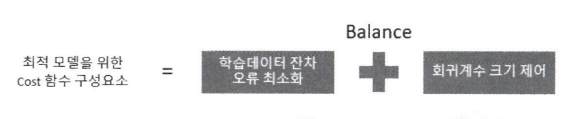


- 회귀 계수의 크기를 제어해 과적합을 개선하려면 

=> 비용(Cost) 함수의 목표가 비용 함수 목표로 변경

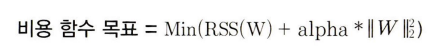

- alpha: 학습 데이터 적합 정도, 회귀 계수 값의 크기 제어 수행
> - alpha가 0(또는 매우 작은 값) -> 비용 함수 식은 기존과 동일한 Min(RSS(W) + 0
 - alpha 무한대(또는 매우 큰 값) -> 비용 함수 식은 RSS(W)에 비해 alpha*||W||22 값이 너무 커지게 됨.  
=> W 값을 0(또는 매우 작게)으로 만들어야 Cost가 최소화되는 비용 함수 목표를 달성할 수 있다.

- alpha 값을 크게 하면 -> 비용 함수는 회귀 계수 W의 값을 작게 해 과적합 개선
- alpha 값을 작게 하면 -> 회귀 계수 W의 값이 커져도 어느 정도 상쇄가 가능하므로 학습 데이터 적합을 더 개선

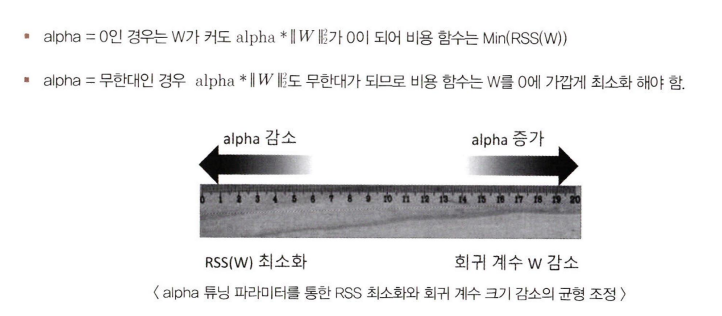


=> alpha를 0에서부터 지속적으로 값을 증가시키면 회귀 계수 값의 크기를 감소시킬 수 있다.

**규제(Regularization)**: 비용 함수에 alpha 값으로 패널티를 부여해 회귀 계수 값의 크기를 감소시켜 과적합을 개선하는 방식
- L2 방식: W의 제곱에 페널티 부여 => L2 규제를 적용한 회귀: **릿지(Ridge) 회귀**
- L1 방식: W의 절댓값에 패널티 부여 => L1 규제를 적용 -> 영향력이 크지 않은 회귀 계수 값을 0으로 변환

### 2) 릿지 회귀

주요 생성 파라미터: alpha (릿지 회귀의 alpha L2 규제 계수)

- 보스턴 주택 가격 Ridge 클래스 이용해 예측 후 cross_val_score()로 예측 성능 평가

In [ ]:
# import package
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# 앞의 LinearRegression예제에서 분할한 feature 데이터 셋인 X_data과 Target 데이터 셋인 Y_target 데이터셋을 그대로 이용 
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
boston = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :3]])

feature_names=['CRIM',	'ZN',	'INDUS',	'CHAS',	'NOX',	'RM',	'AGE',	'DIS',	'RAD',	'TAX'	,'PTRATIO',	'B'	,'LSTAT',	'PRICE']
bostonDF = pd.DataFrame(boston, columns=feature_names)
print('Boston 데이터 세트 크기:', bostonDF.shape)
bostonDF.head()

y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'],axis=1,inplace=False)

# alpha = 10으로 설정해 릿지 회귀 수행.
ridge = Ridge(alpha = 10)
neg_mse_scores = cross_val_score(ridge, X_data, y_target, scoring="neg_mean_squared_error", cv = 5)
rmse_scores  = np.sqrt(-1 * neg_mse_scores)
avg_rmse = np.mean(rmse_scores)
print(' 5 folds 의 개별 Negative MSE scores: ', np.round(neg_mse_scores, 3))
print(' 5 folds 의 개별 RMSE scores : ', np.round(rmse_scores,3))
print(' 5 folds 의 평균 RMSE : {0:.3f} '.format(avg_rmse))

Boston 데이터 세트 크기: (506, 14)
 5 folds 의 개별 Negative MSE scores:  [-11.422 -24.294 -28.144 -74.599 -28.517]
 5 folds 의 개별 RMSE scores :  [3.38  4.929 5.305 8.637 5.34 ]
 5 folds 의 평균 RMSE : 5.518 


=> 릿지의 5개 폴드 세트의 평균 RMSE: 5.518

(LinearRegression의 RMSE보다 더 뛰어난 예측 성능을 보임.)

- alpha값을 0 , 0.1 , 1 , 10 , 100 으로 변경하면서 RMSE와 회귀 계수 값의 변화 측정

In [ ]:
# 릿지에 사용될 alpha 파라미터의 값을 정의
alphas = [0, 0.1, 1, 10, 100]

# alphas list 값을 반복하면서 alpha에 따른 평균 rmse를 구함.
for alpha in alphas :
    ridge = Ridge(alpha = alpha)
    
    # cross_val_score를 이용해 5 폴드의 평균 RMSE를 계산
    neg_mse_scores = cross_val_score(ridge, X_data, y_target, scoring="neg_mean_squared_error", cv = 5)
    avg_rmse = np.mean(np.sqrt(-1 * neg_mse_scores))
    print('alpha {0} 일 때 5 folds 의 평균 RMSE : {1:.3f} '.format(alpha, avg_rmse))
    

alpha 0 일 때 5 folds 의 평균 RMSE : 5.829 
alpha 0.1 일 때 5 folds 의 평균 RMSE : 5.788 
alpha 1 일 때 5 folds 의 평균 RMSE : 5.653 
alpha 10 일 때 5 folds 의 평균 RMSE : 5.518 
alpha 100 일 때 5 folds 의 평균 RMSE : 5.330 


=> alpha=100일 때 평균 RMSE가 5.829로 가장 좋다.

- 각 alpha에 따른 회귀 계수 값을 시각화. 각 alpha값 별로 plt.subplots로 맷플롯립 축 생성

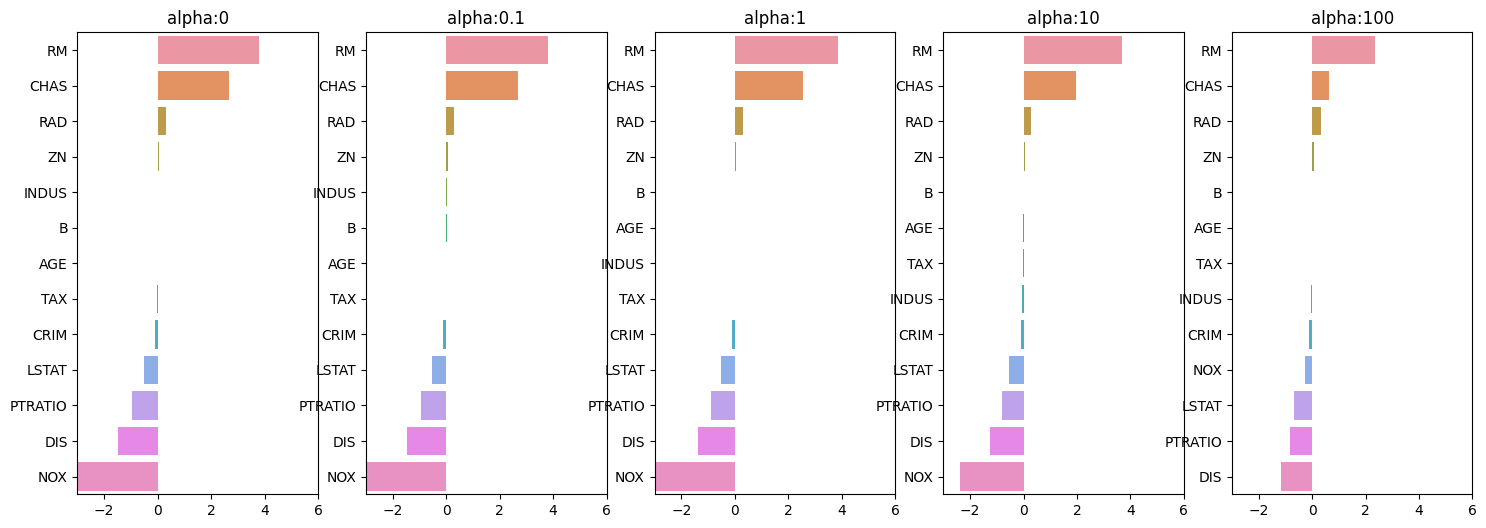

In [ ]:
# 각 alpha에 따른 회귀 계수 값을 시각화하기 위해 5개의 열로 된 맷플롯립 축 생성  
fig , axs = plt.subplots(figsize=(18,6) , nrows=1 , ncols=5)
# 각 alpha에 따른 회귀 계수 값을 데이터로 저장하기 위한 DataFrame 생성  
coeff_df = pd.DataFrame()

# alphas 리스트 값을 차례로 입력해 회귀 계수 값 시각화 및 데이터 저장. pos는 axis의 위치 지정
for pos , alpha in enumerate(alphas) :
    ridge = Ridge(alpha = alpha)
    ridge.fit(X_data , y_target)
    # alpha에 따른 피처별 회귀 계수를 Series로 변환하고 이를 DataFrame의 컬럼으로 추가.  
    coeff = pd.Series(data=ridge.coef_ , index=X_data.columns )
    colname='alpha:'+str(alpha)
    coeff_df[colname] = coeff
    # 막대 그래프로 각 alpha 값에서의 회귀 계수를 시각화. 회귀 계수값이 높은 순으로 표현
    coeff = coeff.sort_values(ascending=False)
    axs[pos].set_title(colname)
    axs[pos].set_xlim(-3,6)
    sns.barplot(x=coeff.values , y=coeff.index, ax=axs[pos])

# for 문 바깥에서 맷플롯립의 show 호출 및 alpha에 따른 피처별 회귀 계수를 DataFrame으로 표시
plt.show()

=> alpha 값을 계속 증가시킬수록 회귀 계수 값이 지속적으로 작아짐.

- alpha 값에 따른 컬럼별 회귀계수 출력

In [ ]:
ridge_alphas = [0 , 0.1 , 1 , 10 , 100]
sort_column = 'alpha:'+str(ridge_alphas[0])
coeff_df.sort_values(by=sort_column, ascending=False)

,alpha:0,alpha:0.1,alpha:1,alpha:10,alpha:100
RM,3.809865,3.818233,3.854000,3.702272,2.334536
CHAS,2.686734,2.670019,2.552393,1.952021,0.638335
RAD,0.306049,0.303515,0.290142,0.279596,0.315358
ZN,0.046420,0.046572,0.047443,0.049579,0.054496
INDUS,0.020559,0.015999,-0.008805,-0.042962,-0.052826
B,0.009312,0.009368,0.009673,0.010037,0.009393
AGE,0.000692,-0.000269,-0.005415,-0.010707,0.001212
TAX,-0.012335,-0.012421,-0.012912,-0.013993,-0.015856
CRIM,-0.108011,-0.107474,-0.104595,-0.101435,-0.102202
LSTAT,-0.524758,-0.525966,-0.533343,-0.559366,-0.660764


=> alpha 값이 증가하면서 회귀 계수가 지속적으로 작아지고 있음.

but, 릿지 회귀의 경우에는 회귀 계수를 0으로 만들지는 않는다.

### 3) 라쏘 회귀

라쏘(Lasso) 회귀: W의 절댓값에 페널티는 부여하는 L1 규제를 선형 회귀에 적용한 것
- 불필요한 회귀 계수를 급격하게 감소시켜 0으로 만들고 제거
- 적절한 피처만 회귀에 포함시키는 피처 선택의 특성
- 라쏘 회귀 비용함수의 목표는 다음 식을 최소화하는 W를 찾는 것
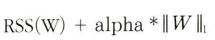

In [ ]:
from sklearn.linear_model import Lasso, ElasticNet

# alpha값에 따른 회귀 모델의 폴드 평균 RMSE를 출력하고 회귀 계수값들을 DataFrame으로 반환 
def get_linear_reg_eval(model_name, params=None, X_data_n=None, y_target_n=None, 
                        verbose=True, return_coeff=True):
    coeff_df = pd.DataFrame()
    if verbose : print('####### ', model_name , '#######')
    for param in params:
        if model_name =='Ridge': model = Ridge(alpha=param)
        elif model_name =='Lasso': model = Lasso(alpha=param)
        elif model_name =='ElasticNet': model = ElasticNet(alpha=param, l1_ratio=0.7)
        neg_mse_scores = cross_val_score(model, X_data_n, 
                                             y_target_n, scoring="neg_mean_squared_error", cv = 5)
        avg_rmse = np.mean(np.sqrt(-1 * neg_mse_scores))
        print('alpha {0}일 때 5 폴드 세트의 평균 RMSE: {1:.3f} '.format(param, avg_rmse))
        # cross_val_score는 evaluation metric만 반환하므로 모델을 다시 학습하여 회귀 계수 추출
        
        model.fit(X_data_n , y_target_n)
        if return_coeff:
            # alpha에 따른 피처별 회귀 계수를 Series로 변환하고 이를 DataFrame의 컬럼으로 추가. 
            coeff = pd.Series(data=model.coef_ , index=X_data_n.columns )
            colname='alpha:'+str(param)
            coeff_df[colname] = coeff
    
    return coeff_df
# end of get_linear_regre_eval


- alpha 값의 변화에 따른 RMSE와 그때의 회귀계수 출력

In [ ]:
# 라쏘에 사용될 alpha 파라미터의 값들을 정의하고 get_linear_reg_eval() 함수 호출
lasso_alphas = [ 0.07, 0.1, 0.5, 1, 3]
coeff_lasso_df =get_linear_reg_eval('Lasso', params=lasso_alphas, X_data_n=X_data, y_target_n=y_target)


#######  Lasso #######
alpha 0.07일 때 5 폴드 세트의 평균 RMSE: 5.612 
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.615 
alpha 0.5일 때 5 폴드 세트의 평균 RMSE: 5.669 
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.776 
alpha 3일 때 5 폴드 세트의 평균 RMSE: 6.189 


=> alpha=0.07일 때 가장 좋은 평균 RMSE를 보여준다.

(릿지 평균보다는 약간 떨어지는 수치지만, LinearRegression의 평균보다는 향상됨.)

- alpha 값에 따른 피처별 회귀 계수

In [ ]:
# 반환된 coeff_lasso_df를 첫번째 컬럼순으로 내림차순 정렬하여 회귀계수 DataFrame출력
sort_column = 'alpha:'+str(lasso_alphas[0])
coeff_lasso_df.sort_values(by=sort_column, ascending=False)

,alpha:0.07,alpha:0.1,alpha:0.5,alpha:1,alpha:3
RM,3.789725,3.703202,2.498212,0.949811,0.000000
CHAS,1.434343,0.955190,0.000000,0.000000,0.000000
RAD,0.270936,0.274707,0.277451,0.264206,0.061864
ZN,0.049059,0.049211,0.049544,0.049165,0.037231
B,0.010248,0.010249,0.009469,0.008247,0.006510
NOX,-0.000000,-0.000000,-0.000000,-0.000000,0.000000
AGE,-0.011706,-0.010037,0.003604,0.020910,0.042495
TAX,-0.014290,-0.014570,-0.015442,-0.015212,-0.008602
INDUS,-0.042120,-0.036619,-0.005253,-0.000000,-0.000000
CRIM,-0.098193,-0.097894,-0.083289,-0.063437,-0.000000


=> alpha의 크기가 증가함에 따라 일부 피처의 회귀 계수가 아예 0으로 바뀌고 있다.

(NOX 속성은 alpha=0.07일 때부터 회귀 계수가 0이며, alpha를 증가시키면서 INDUS, CHAS와 같은 속성의 회귀 계수도 0으로 바뀜.)

=> 회귀 계수가 0인 피처는 회귀 식에서 제외되면서 피처 선택의 효과를 얻을 수 있다.

### 4) 엘라스틱넷 회귀

엘라스틱넷(Elastic Net) 회귀: **L2 규제 + L1 규제** 결합한 회귀

- 엘라스틱넷 비용함수의 목표는 RSS(W) + alpha2||W|| + alpha1||W|| 식을 최소화하는 W를 찾는 것

- 라쏘 회귀가 서로 상관관계가 높은 피처들의 경우에 이들 중에서 중요 피처만을 셀렉션하고 다른 피처들은 모두 회귀 계수를 0으로 만드는 성향이 강하다. 이러한 성향으로 인해 alpha 값에 따라 회귀 계수의 값이 급격히 변동할 수 있는데, 엘라스틱넷 회귀는 이를 완화하기 위해 L2 규제를 라쏘 회귀에 추가한 것.

- 사이킷런은 ElasticNet 클래스를 통해 엘라스틱넷 회귀 구현
- 주요 생성 파라미터는 alpha와 l1_ratio
    - 엘라스틱넷의 규제는 aL1 + bL2로 정의(a는 L1 규제의 alpha 값, b는 L2 규제의 alpha 값)
    - alpha 파라미터 값 = a+b
    - l1_ratio 파라미터 값 = a/(a+b) -> l1_ratio가 0이면 L2 규제와 동일/l1_ratio가 1이면 L1 규제와 동일

- alpha 값을 변화시키면서 RMSE와 각 피처의 회귀 계수 출력

In [ ]:
# 엘라스틱넷에 사용될 alpha 파라미터의 값들을 정의하고 get_linear_reg_eval() 함수 호출
# l1_ratio는 0.7로 고정
elastic_alphas = [ 0.07, 0.1, 0.5, 1, 3]
coeff_elastic_df =get_linear_reg_eval('ElasticNet', params=elastic_alphas,
                                      X_data_n=X_data, y_target_n=y_target)


#######  ElasticNet #######
alpha 0.07일 때 5 폴드 세트의 평균 RMSE: 5.542 
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.526 
alpha 0.5일 때 5 폴드 세트의 평균 RMSE: 5.467 
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.597 
alpha 3일 때 5 폴드 세트의 평균 RMSE: 6.068 


In [ ]:
# 반환된 coeff_elastic_df를 첫번째 컬럼순으로 내림차순 정렬하여 회귀계수 DataFrame출력
sort_column = 'alpha:'+str(elastic_alphas[0])
coeff_elastic_df.sort_values(by=sort_column, ascending=False)


,alpha:0.07,alpha:0.1,alpha:0.5,alpha:1,alpha:3
RM,3.574162,3.414154,1.918419,0.938789,0.000000
CHAS,1.330724,0.979706,0.000000,0.000000,0.000000
RAD,0.278880,0.283443,0.300761,0.289299,0.146846
ZN,0.050107,0.050617,0.052878,0.052136,0.038268
B,0.010122,0.010067,0.009114,0.008320,0.007020
AGE,-0.010116,-0.008276,0.007760,0.020348,0.043446
TAX,-0.014522,-0.014814,-0.016046,-0.016218,-0.011417
INDUS,-0.044855,-0.042719,-0.023252,-0.000000,-0.000000
CRIM,-0.099468,-0.099213,-0.089070,-0.073577,-0.019058
NOX,-0.175072,-0.000000,-0.000000,-0.000000,-0.000000


=> alpha 0.5일 때 RMSE가 5.467로 가장 좋은 예측 성능. alpha값에 따른 피처들의 회귀 계수들 값이 라쏘보다는 상대적으로 0이 되는 값이 적음.

### 5) 선형 회귀 모델을 위한 데이터 변환

일반적으로 중요 피처들이나 타깃값의 분포도가 심하게 왜곡됐을 경우에 **데이터에 대한 스케일링/정규화 작업** 수행(무조건 예측 성능 향상되는 것은 x)

- 피처 데이터 세트에 적용하는 변환 작업
    - StandardScaler 클래스 이용 or MinMaxScaler 클래스 이용
    - 스케일링/정규화를 수행한 데이터 세트에 다시 다항 특성 적용해 변환
    - 로그 변환(매우 유용) np.log1p()(<- 언더 플로우 발생하기 쉬워 1+log()함수 적용)
- 타깃값의 경우는 일반적으로 로그 변환 적용
- 표준 정규 분포 변환, 최댓값/최솟값 정규화, 로그 변환 차례로 적용한 후에 RMSE로 각 경우별 예측 성능 측정 
- 함수 생성

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures

# method는 표준 정규 분포 변환(Standard), 최대값/최소값 정규화(MinMax), 로그변환(Log) 결정
# p_degree는 다향식 특성을 추가할 때 적용. p_degree는 2이상 부여하지 않음. 
def get_scaled_data(method='None', p_degree=None, input_data=None):
    if method == 'Standard':
        scaled_data = StandardScaler().fit_transform(input_data)
    elif method == 'MinMax':
        scaled_data = MinMaxScaler().fit_transform(input_data)
    elif method == 'Log':
        scaled_data = np.log1p(input_data)
    else:
        scaled_data = input_data

    if p_degree != None:
        scaled_data = PolynomialFeatures(degree=p_degree, 
                                         include_bias=False).fit_transform(scaled_data)
    
    return scaled_data
    

- Ridge 클래스의 alpha 값을 변화시키면서 피처 데이터 세트를 여러 가지 방법으로 변환한 데이터 세트를 입력 받을 경우에 RMSE 값이 어떻게 변하는지 확인

In [ ]:
# Ridge의 alpha값을 다르게 적용하고 다양한 데이터 변환방법에 따른 RMSE 추출. 
alphas = [0.1, 1, 10, 100]
#변환 방법은 모두 6개, 원본 그대로, 표준정규분포, 표준정규분포+다항식 특성
# 최대/최소 정규화, 최대/최소 정규화+다항식 특성, 로그변환 
scale_methods=[(None, None), ('Standard', None), ('Standard', 2), 
               ('MinMax', None), ('MinMax', 2), ('Log', None)]
for scale_method in scale_methods:
    X_data_scaled = get_scaled_data(method=scale_method[0], p_degree=scale_method[1], 
                                    input_data=X_data)
    print(X_data_scaled.shape, X_data.shape)
    print('\n## 변환 유형:{0}, Polynomial Degree:{1}'.format(scale_method[0], scale_method[1]))
    get_linear_reg_eval('Ridge', params=alphas, X_data_n=X_data_scaled, 
                        y_target_n=y_target, verbose=False, return_coeff=False)
  

(506, 13) (506, 13)

## 변환 유형:None, Polynomial Degree:None
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.788 
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.653 
alpha 10일 때 5 폴드 세트의 평균 RMSE: 5.518 
alpha 100일 때 5 폴드 세트의 평균 RMSE: 5.330 
(506, 13) (506, 13)

## 변환 유형:Standard, Polynomial Degree:None
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.826 
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.803 
alpha 10일 때 5 폴드 세트의 평균 RMSE: 5.637 
alpha 100일 때 5 폴드 세트의 평균 RMSE: 5.421 
(506, 104) (506, 13)

## 변환 유형:Standard, Polynomial Degree:2
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 8.827 
alpha 1일 때 5 폴드 세트의 평균 RMSE: 6.871 
alpha 10일 때 5 폴드 세트의 평균 RMSE: 5.485 
alpha 100일 때 5 폴드 세트의 평균 RMSE: 4.634 
(506, 13) (506, 13)

## 변환 유형:MinMax, Polynomial Degree:None
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.764 
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.465 
alpha 10일 때 5 폴드 세트의 평균 RMSE: 5.754 
alpha 100일 때 5 폴드 세트의 평균 RMSE: 7.635 
(506, 104) (506, 13)

## 변환 유형:MinMax, Polynomial Degree:2
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.298 
alpha 1일 때 5 폴드 세트의 평균 RMSE: 4.323 
alpha 10일 때 5 폴드 세트의 평균 RMS

=> 일반적으로 선형 회귀를 적용하려는 데이터 세트에 데이터 값의 분포가 심하게 왜곡되어 있을 경우에 로그 변환 적용하는 것

## 07. 로지스틱 회귀

로지스틱 회귀 : 선형 회귀 방식을 분류에 적용한 알고리즘

- 시그모이드(sigmoid) 함수 최적선을 찾고 이 시그모이드 함수의 반환 값을 확률로 간주해 확률에 따라 분류를 결정하는 것 (<->선형회귀: 선형 함수의 회귀 최적선 찾는 것)

- 많은 자연, 사회 현상에서 특정 변수의 확률 값은 선형이 아니라 시그모이드 함수와 같이 S자 커브 형태

- 시그모이드 함수 y=1/(1+e^(-x)). y값은 항상 0과 1 사이 값 반환

=> 로지스틱 회귀 : 선형 회귀 방식을 기반으로 하되 시그모이드 함수를 이용해 분류를 수행하는 회귀


- 위스콘신 유방암 데이터 세트 이용해 로지스틱 회귀로 암 여부 판단
전체 데이터 세트 생성

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression

cancer=load_breast_cancer()

- 먼저 정규 분포 형태의 표준 스케일링 적용 후 데이터 세트 분리 (<- 데이터 정규 분포도에 따라 예측 성능 영향 받을 수 있어)

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# StandardScaler()로 평균이 0, 분산 1로 데이터 분포도 변환
scaler=StandardScaler()
data_scaled=scaler.fit_transform(cancer.data)

X_train, X_test, y_train, y_test = train_test_split(data_scaled, cancer.target, test_size=0.3, random_state=0)


- 로지스틱 회귀 이용해 학습 및 예측 수행. 정확도와 ROC-AUC 값.

In [4]:
from sklearn.metrics import accuracy_score, roc_auc_score

# 로지스틱 회귀를 이용해 학습 및 예측 수행.
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
lr_preds=lr_clf.predict(X_test)

# 정확도와 roc_auc 측정
print('accuracy: {:0.3f}'.format(accuracy_score(y_test, lr_preds)))
print('roc_auc: {:0.3f}'.format(roc_auc_score(y_test, lr_preds)))

accuracy: 0.977
roc_auc: 0.972



=> 정확도가 약 0.977, ROC-AUC가 약 0.972

- 사이킷런 LogisticRegression 클래스의 주요 하이퍼 파라미터 - penalty와 C
    - penalty : 규제의 유형 설정. 'l2'로 설정 시 L2규제.'l1'으로 설정 시 L1 규제(기본은 'l2')
    - C : 규제 강도를 조절하는 alpha값의 역수. 1/alpha. C값이 작을수록 규제 강도 커

- GridSearchCV를 이용해 하이퍼 파라미터 최적화

In [5]:
from sklearn.model_selection import GridSearchCV

params={'penalty':['l2','l1'],
        'C':[0.01, 0.1, 1, 1, 5, 10]}

grid_clf = GridSearchCV(lr_clf, param_grid=params, scoring='accuracy', cv=3)
grid_clf.fit(data_scaled, cancer.target)
print('최적 하이퍼 파라미터:{0}, 최적 평균 정확도:{1:.3f}'.format(grid_clf.best_params_, grid_clf.best_score_))


최적 하이퍼 파라미터:{'C': 1, 'penalty': 'l2'}, 최적 평균 정확도:0.975


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
18 fits failed out of a total of 36.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
18 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Solve

- 로지스틱 회귀 : 가볍고 빨라 + 이진 분류 예측 성능도 뛰어나 + 희소한 데이터 세트 분류에도 뛰어난 성능 -> 텍스트 분류에서도 자주 사용

## 08. 회귀 트리

머신러닝 기반의 회귀는 회귀 계수를 기반으로 하는 최적 회귀 함수를 도출하는 것이 주요 목표.

**회귀 트리** : 회귀를 위한 트리를 생성하고 이를 기반으로 회귀 예측을 하는 것(회귀 함수 기반x -> 트리 기반)

- 분류 트리와 크게 다르지 않지만, 회귀 트리는 리프 노드에 속한 데이터 값의 평균값을 구해 회귀 예측값 계산

- 트리 생성이 CART(Classification And Regression Trees) 알고리즘 기반

-> 결정 트리, 랜덤 포레스트, GBM, XGBoost, LightGBM 등의 모든 트리 기반 알고리즘은 분류, 회귀 모두 가능

- 사이킷런의 트리 기반 회귀와 분류의 Estimator 클래스

> - Decision Tree : DecisionTreeRegressor/DecisionTreeClassifier  
- Gradient Boosting : GradinetBoostingRegressor/GradientBoostingClassifier  
- XGBoost : XGBRegressor/XGBClassifier  
- LightGBM : LGBMRegressor/LGBMClassifier  

- 랜덤 포레스트 회귀 트리인 RandomForestRegressor 이용해 보스턴 주택 가격 예측 수행

In [7]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np

# 보스턴 데이터 세트 로드
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
boston = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :3]])
feature_names=['CRIM',	'ZN',	'INDUS',	'CHAS',	'NOX',	'RM',	'AGE',	'DIS',	'RAD',	'TAX'	,'PTRATIO',	'B'	,'LSTAT',	'PRICE']
bostonDF = pd.DataFrame(boston, columns=feature_names)

y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'], axis=1, inplace=False)

rf = RandomForestRegressor(random_state=0, n_estimators=1000)
neg_mse_scores = cross_val_score(rf, X_data, y_target, scoring="neg_mean_squared_error", cv=5)
rmse_scores = np.sqrt(-1*neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

print(' 5 교차 검증의 개별 Negative MSE scores : ', np.round(neg_mse_scores, 2))
print(' 5 교차 검증의 개별 RMSE scores : ', np.round(rmse_scores, 2))
print(' 5 교차 검증의 평균 RMSE : {0:.3f} '.format(avg_rmse))


 5 교차 검증의 개별 Negative MSE scores :  [ -7.88 -13.14 -20.57 -46.23 -18.88]
 5 교차 검증의 개별 RMSE scores :  [2.81 3.63 4.54 6.8  4.34]
 5 교차 검증의 평균 RMSE : 4.423 


- 결정트리, GBM, XGBoost, LightGBM의 Regressor 모두 이용해 예측 수행 - 입력 모델과 데이터 세트 입력받아 교차 검증으로 평균 RMSE 계산해주는 함수 생성

In [8]:
def get_model_cv_prediction(model, X_data, y_target):
  neg_mse_scores = cross_val_score(model, X_data, y_target, scoring="neg_mean_squared_error", cv=5)
  rmse_scores = np.sqrt(-1*neg_mse_scores)
  avg_rmse = np.mean(rmse_scores)
  print('##### ', model.__class__.__name__, ' #####')
  print(' 5 교차 검증의 평균 RMSE : {0:.3f} '.format(avg_rmse))
  

In [9]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

dt_reg = DecisionTreeRegressor(random_state=0, max_depth=4)
rf_reg = RandomForestRegressor(random_state=0, n_estimators=1000)
gb_reg = GradientBoostingRegressor(random_state=0, n_estimators=1000)
xgb_reg = XGBRegressor(n_estimators=1000)
lgb_reg = LGBMRegressor(n_estimators=1000)

# 트리 기반의 회귀 모델을 반복하면서 평가 수행
models = [dt_reg, rf_reg, gb_reg, xgb_reg, lgb_reg]
for model in models:
  get_model_cv_prediction(model, X_data, y_target)
  

#####  DecisionTreeRegressor  #####
 5 교차 검증의 평균 RMSE : 5.978 
#####  RandomForestRegressor  #####
 5 교차 검증의 평균 RMSE : 4.423 
#####  GradientBoostingRegressor  #####
 5 교차 검증의 평균 RMSE : 4.269 
#####  XGBRegressor  #####
 5 교차 검증의 평균 RMSE : 4.251 
#####  LGBMRegressor  #####
 5 교차 검증의 평균 RMSE : 4.646 


- 회귀 트리 Regressor 클래스는 회귀 계수 제공하는 coef_ 속성 x -> 
  feature_importances_ 이용해 피처별 중요도 시각화

<Axes: >

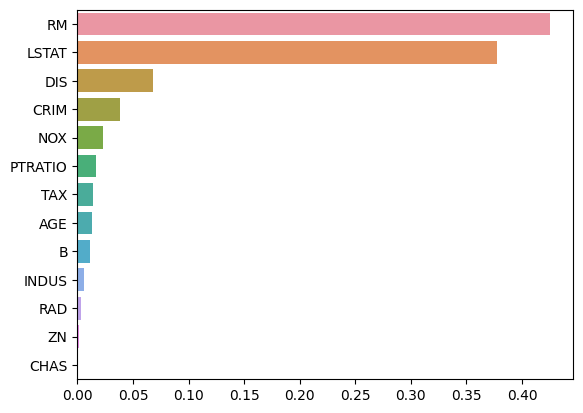

In [10]:
import seaborn as sns
%matplotlib inline

rf_reg = RandomForestRegressor(n_estimators=1000)

# 앞 예제에서 만들어진 X_data, y_target 데이터 세트를 적용해 학습합니다.
rf_reg.fit(X_data, y_target)

feature_series = pd.Series(data=rf_reg.feature_importances_, index=X_data.columns)
feature_series = feature_series.sort_values(ascending=False)
sns.barplot(x=feature_series, y=feature_series.index)


- 회귀 트리 Regressor의 하이퍼 파라미터는 분류 트리 Classifier와 거의 동일
- 회귀 트리 Regressor가 어떻게 예측값을 판단하는지 선형 회귀와 비교해 시각화
    - 결정 트리의 하이퍼 파라미터인 max_depth의 크기를 변화시키면서 어떻게 회귀 트리 예측선이 변화하는지. 단 1개의 변수만 추출(Price와 가장 밀접한 양의 상관관계 갖는 RM 칼럼)

(100, 2)


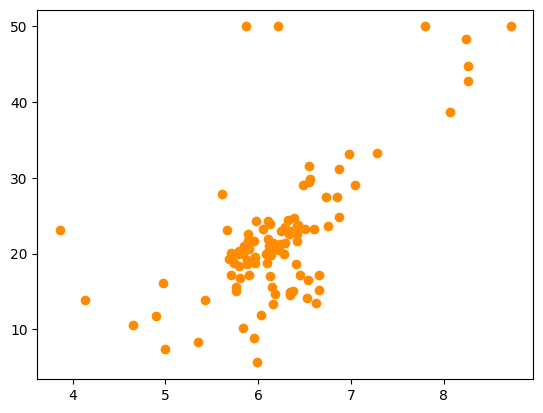

In [11]:
bostonDF_sample = bostonDF[['RM','PRICE']]
bostonDF_sample = bostonDF_sample.sample(n=100, random_state=0)
print(bostonDF_sample.shape)
plt.figure()
plt.scatter(bostonDF_sample.RM, bostonDF_sample.PRICE, c="darkorange")


- LinearRegresson과 DecisionTreeRegressor를 max_depth를 각각 2,7로 해서 학습 -> 학습된 Regressor에 RM 값을 4.5~8.5까지의 100개의 테스트 데이터 세트로 제공했을 때 예측값 구하기

In [12]:
import numpy as np
from sklearn.linear_model import LinearRegression

# 선형 회귀와 결정 트리 기반의 Regressor 생성. DecisionTreeRegressor의 max_depth는 각각 2,7
lr_reg = LinearRegression()
rf_reg2 = DecisionTreeRegressor(max_depth=2)
rf_reg7 = DecisionTreeRegressor(max_depth=7)

# 실제 예측을 적용할 테스트용 데이터 세트를 4.5~ 8.5까지의 100개 데이터 세트로 생성.
X_test = np.arange(4.5, 8.5, 0.04).reshape(-1,1)

# 보스턴 주택 가격 데이터에서 시각화를 위해 피처는 RM만, 그리고 결정 데이터인 PRICE 추출
X_feature = bostonDF_sample['RM'].values.reshape(-1,1)
y_target = bostonDF_sample['PRICE'].values.reshape(-1,1)

# 학습과 예측 수행
lr_reg.fit(X_feature, y_target)
rf_reg2.fit(X_feature, y_target)
rf_reg7.fit(X_feature, y_target)

pred_lr = lr_reg.predict(X_test)
pred_rf2 = rf_reg2.predict(X_test)
pred_rf7 = rf_reg7.predict(X_test)


- 학습된 Regressor에서 예측한 Price 회귀선 그리기

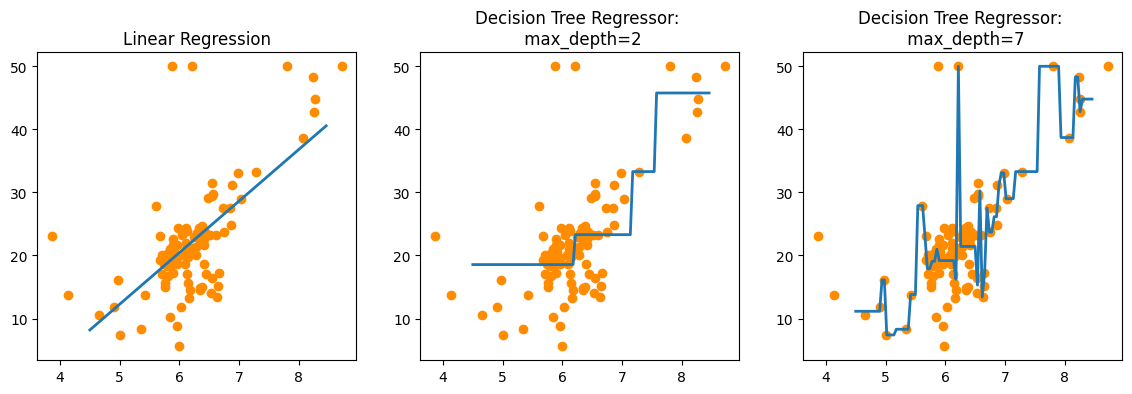

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(14,4), ncols=3)

# X 축 값을 4.5~8.5로 변환하며 입력했을 때 선형 회귀와 결정 트리 회귀 예측선 시각화
# 선형 회귀로 학습된 모델 회귀 예측선
ax1.set_title('Linear Regression')
ax1.scatter(bostonDF_sample.RM, bostonDF_sample.PRICE, c="darkorange")
ax1.plot(X_test, pred_lr, label="linear", linewidth=2)

# DecisionTreeRegressor의 max_depth를 2로 했을 때 회귀 예측선
ax2.set_title('Decision Tree Regressor: \n max_depth=2')
ax2.scatter(bostonDF_sample.RM, bostonDF_sample.PRICE, c="darkorange")
ax2.plot(X_test, pred_rf2, label="max_depth:3", linewidth=2)

# DecisionTreeRegressor의 max_depth를 7로 했을 때 회귀 예측선
ax3.set_title('Decision Tree Regressor: \n max_depth=7')
ax3.scatter(bostonDF_sample.RM, bostonDF_sample.PRICE, c="darkorange")
ax3.plot(X_test, pred_rf7, label="max_depth:7", linewidth=2)


=> 선형 회귀는 직선으로 예측 회귀선 표현 but 회귀 트리의 경우 분할되는 데이터 지점에 따라 브랜치를 만들면서 계단 형태로 회귀선 만들어

=> DecisionTreeRegressor의 max_depth=7 경우 학습 데이터 세트의 이상치 데이터도 학습 -> 복잡한 계단 형태 회귀선 -> 과적합 되기 쉬운 모델